In [1]:
!nvidia-smi

Thu Sep  1 19:38:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   40C    P0    43W / 300W |   3313MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!python3 -m pip install mxnet-cu110

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
import mxnet as mx

import time

In [4]:
x_mx_cpu = mx.np.random.rand(1000, 1000, ctx = mx.cpu())
start_time = time.time()
mx.np.dot(x_mx_cpu, x_mx_cpu).wait_to_read() 
print("Time of the operation: ", time.time() - start_time)

Time of the operation:  0.03418850898742676


In [5]:
x_mx_cpu = mx.np.random.rand(1000, 1000, ctx = mx.cpu())
start_time = time.time()
x_2 = mx.np.dot(x_mx_cpu, x_mx_cpu)
print("(FAKE, MXNet has lazy evaluation)") 
print("Time of the operation : ", time.time() - start_time) 
start_time = time.time() 
print(x_2) 
print("(FAKE, MXNet has lazy evaluation)") 
print("Time to display: ", time.time() - start_time)

(FAKE, MXNet has lazy evaluation)
Time of the operation :  0.0007123947143554688
[[258.81516 255.33388 254.32779 ... 249.17023 255.54128 250.86026]
 [253.10114 249.83322 251.44133 ... 246.73381 255.79558 246.69646]
 [237.1145  233.8821  239.16486 ... 229.9818  238.70709 229.368  ]
 ...
 [257.0594  259.1641  255.50027 ... 252.1665  257.4544  247.9076 ]
 [245.73749 249.5228  251.82219 ... 239.48169 247.73837 236.19794]
 [248.97461 256.00775 247.82782 ... 248.81781 251.12112 248.77133]]
(FAKE, MXNet has lazy evaluation)
Time to display:  0.02734827995300293


In [6]:
timings_np = {}
timings_mx_np_cpu = {}
timings_mx_np_gpu = {}
timings_mx_nd_cpu = {}
timings_mx_nd_gpu = {}
matrix_orders = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000]

In [7]:
def create_matrix_np(n):
    """
    Given n, creates a squared n x n matrix,
    with each matrix value taken from a random
    uniform distribution between [0, 1].
    Returns the created matrix a.
    Uses NumPy.
    """
    a = np.random.rand(n, n)
    return a

def create_matrix_mx_np(n, ctx=mx.cpu()):
    """
    Given n, creates a squared n x n matrix,
    with each matrix value taken from a random
    uniform distribution between [0, 1].
    Returns the created matrix a.
    Uses MXNet NumPy syntax and context ctx
    """
    a = mx.np.random.rand(n, n, ctx=ctx)
    a.wait_to_read()
    return a

def create_matrix_mx_nd(n, ctx=mx.cpu()):
    """
    Given n, creates a squared n x n matrix,
    with each matrix value taken from a random
    uniform distribution between [0, 1].
    Returns the created matrix a.
    Uses MXNet ND native syntax and context ctx
    """
    a = mx.nd.random.uniform(shape=(n, n), ctx=ctx)
    a.wait_to_read()
    return a

In [8]:
timings_np["create"] = []

for n in matrix_orders:
    result = %timeit -o create_matrix_np(n)
    timings_np["create"].append(result.average)

901 ns ± 1.88 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.09 µs ± 1.97 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.75 µs ± 3.43 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
22.7 µs ± 13.8 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
86.7 µs ± 9 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2.13 ms ± 165 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.49 ms ± 588 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
265 ms ± 917 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.08 s ± 619 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
timings_mx_np_cpu["create"] = []

for n in matrix_orders:
    result = %timeit -o create_matrix_mx_np(n)
    timings_mx_np_cpu["create"].append(result.average)

153 µs ± 389 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
174 µs ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
151 µs ± 680 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
206 µs ± 7.53 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
274 µs ± 763 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.14 ms ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.85 ms ± 4.19 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
236 ms ± 26.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
942 ms ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
timings_mx_np_gpu["create"] = []

ctx = mx.gpu()
for n in matrix_orders:
    result = %timeit -o create_matrix_mx_np(n, ctx)
    timings_mx_np_gpu["create"].append(result.average)

244 µs ± 75.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
205 µs ± 12 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
201 µs ± 2.67 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
220 µs ± 9.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
206 µs ± 2.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
202 µs ± 2.02 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
223 µs ± 4.69 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
711 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.43 ms ± 4.04 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
timings_mx_nd_cpu["create"] = []

for n in matrix_orders:
    result = %timeit -o create_matrix_mx_nd(n)
    timings_mx_nd_cpu["create"].append(result.average)

114 µs ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
108 µs ± 7.66 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
108 µs ± 6.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
132 µs ± 5.11 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
178 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
967 µs ± 621 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.22 ms ± 1.83 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
98.6 ms ± 78.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
395 ms ± 383 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
timings_mx_nd_gpu["create"] = []

ctx = mx.gpu()
for n in matrix_orders:
    result = %timeit -o create_matrix_mx_nd(n, ctx)
    timings_mx_nd_gpu["create"].append(result.average)

180 µs ± 6.93 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
184 µs ± 10 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
190 µs ± 2.12 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
210 µs ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
199 µs ± 6.94 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
233 µs ± 6.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
249 µs ± 6.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.59 ms ± 7.81 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15.3 ms ± 6.85 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
def multiply_matrix_np(a, b):
    """
    Multiplies 2 squared matrixes a and b
    and returns the result c.
    Uses NumPy.
    """
    #c = np.matmul(a, b)
    c = np.dot(a, b)
    return c

def multiply_matrix_mx_np(a, b):
    """
    Multiplies 2 squared matrixes a and b
    and returns the result c.
    Uses MXNet NumPy syntax.
    """
    c = mx.np.dot(a, b)
    c.wait_to_read()
    return c

def multiply_matrix_mx_nd(a, b):
    """
    Multiplies 2 squared matrixes a and b
    and returns the result c.
    Uses MXNet ND native syntax.
    """
    c = mx.nd.dot(a, b)
    c.wait_to_read()
    return c

In [17]:
timings_np["multiply"] = []

for n in matrix_orders:
    a = create_matrix_np(n)
    b = create_matrix_np(n)

    result = %timeit -o multiply_matrix_np(a, b)
    timings_np["multiply"].append(result.average)

1.29 µs ± 2.29 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.68 µs ± 0.97 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.89 µs ± 1.06 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
15.7 µs ± 24.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
69.8 µs ± 38.3 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2.87 ms ± 2.93 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
18.1 ms ± 97.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.88 s ± 8.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
14.2 s ± 28.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
timings_mx_np_cpu["multiply"] = []

for n in matrix_orders:
    a = create_matrix_mx_np(n)
    b = create_matrix_mx_np(n)

    result = %timeit -o multiply_matrix_mx_np(a, b)
    timings_mx_np_cpu["multiply"].append(result.average)

82.5 µs ± 4.85 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
87.6 µs ± 6.54 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
87.6 µs ± 4.85 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
100 µs ± 931 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
150 µs ± 2.99 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.18 ms ± 23.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
7.41 ms ± 5.97 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
847 ms ± 595 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.59 s ± 5.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
timings_mx_np_gpu["multiply"] = []

ctx = mx.gpu()
for n in matrix_orders:
    a = create_matrix_mx_np(n, ctx)
    b = create_matrix_mx_np(n, ctx)

    result = %timeit -o multiply_matrix_mx_np(a, b)
    timings_mx_np_gpu["multiply"].append(result.average)

137 µs ± 4.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
135 µs ± 3.29 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
146 µs ± 9.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
142 µs ± 3.21 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
144 µs ± 3.92 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
178 µs ± 1.78 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
324 µs ± 7.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
17.8 ms ± 26.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
143 ms ± 226 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
timings_mx_nd_cpu["multiply"] = []

for n in matrix_orders:
    a = create_matrix_mx_nd(n)
    b = create_matrix_mx_nd(n)

    result = %timeit -o multiply_matrix_mx_nd(a, b)
    timings_mx_nd_cpu["multiply"].append(result.average)

77.9 µs ± 983 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
79.1 µs ± 799 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
82.3 µs ± 2.02 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
101 µs ± 432 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
147 µs ± 3.75 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.16 ms ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
7.5 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
845 ms ± 508 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.62 s ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
timings_mx_nd_gpu["multiply"] = []

ctx = mx.gpu()
for n in matrix_orders:
    a = create_matrix_mx_nd(n, ctx)
    b = create_matrix_mx_nd(n, ctx)

    result = %timeit -o multiply_matrix_mx_nd(a, b)
    timings_mx_nd_gpu["multiply"].append(result.average)

143 µs ± 3.87 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
144 µs ± 8.67 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
140 µs ± 3.21 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
151 µs ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
159 µs ± 6.55 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
184 µs ± 4.83 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
331 µs ± 2.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
17.9 ms ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
144 ms ± 204 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


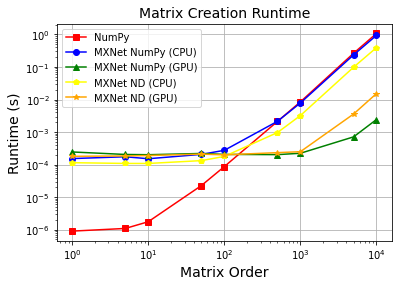

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(matrix_orders, timings_np["create"], color='red', marker='s')
plt.plot(matrix_orders, timings_mx_np_cpu["create"], color='blue', marker='o')
plt.plot(matrix_orders, timings_mx_np_gpu["create"], color='green', marker='^')
plt.plot(matrix_orders, timings_mx_nd_cpu["create"], color='yellow', marker='p')
plt.plot(matrix_orders, timings_mx_nd_gpu["create"], color='orange', marker='*')
plt.title("Matrix Creation Runtime", fontsize=14)
plt.xlabel("Matrix Order", fontsize=14)
plt.ylabel("Runtime (s)", fontsize=14)
plt.grid(True)
ax = fig.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(["NumPy", "MXNet NumPy (CPU)", "MXNet NumPy (GPU)", "MXNet ND (CPU)", "MXNet ND (GPU)"])
plt.show()

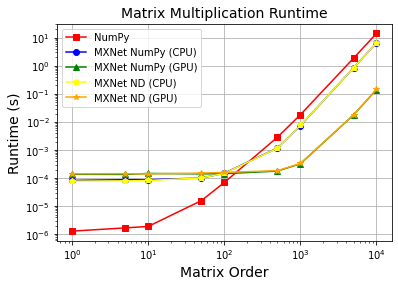

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(matrix_orders, timings_np["multiply"], color='red', marker='s')
plt.plot(matrix_orders, timings_mx_np_cpu["multiply"], color='blue', marker='o')
plt.plot(matrix_orders, timings_mx_np_gpu["multiply"], color='green', marker='^')
plt.plot(matrix_orders, timings_mx_nd_cpu["multiply"], color='yellow', marker='p')
plt.plot(matrix_orders, timings_mx_nd_gpu["multiply"], color='orange', marker='*')
plt.title("Matrix Multiplication Runtime", fontsize=14)
plt.xlabel("Matrix Order", fontsize=14)
plt.ylabel("Runtime (s)", fontsize=14)
plt.grid(True)
ax = fig.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(["NumPy", "MXNet NumPy (CPU)", "MXNet NumPy (GPU)", "MXNet ND (CPU)", "MXNet ND (GPU)"])
plt.show()